In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Mission 1: 패션 스타일 이미지 분류

#### 1-1. 주어진 이미지 데이터의 파일명은 아래와 같은 형식이다.
<pre><code> "{W/T}_{이미지ID}_{시대별}_{스타일별}_{성별}.jpg"</code></pre>

#### 이에 기반하여 "이미지ID" 수 기준으로 성별 & 스타일 통계치를 도출한다.

In [ ]:
import os
# 파일 시스템을 탐색하여 디렉터리 내 파일 목록을 가져오는데 사용
import pandas as pd
# 통계 데이터를 표 형태로 저장하고 출력하는 데 사용
from collections import defaultdict
# 중첩된 딕셔너리 형태로 데이터를 쉽게 저장하기 위해 사용

In [ ]:
# 이미지 파일명에서 성별 및 스타일을 추출하는 함수
def extract_info_from_filename(filename):
    # 파일명 예시: "W_00237_60_popart_W.jpg"
    #             [0] [1] [2]  [3]  [4]
    parts = filename.split('_')
    if len(parts) < 4:
        return None, None
        # 형식이 맞지 않는 파일명은 무시
    style = parts[3]
    # 스타일 정보는 파일명의 구분 중 앞에서 네 번째 요소
    gender = '여성' if parts[-1].startswith('W') else '남성'
    # 성별 정보는 파일명의 구분 중 뒤에서 첫 번째 요소
    return gender, style

In [ ]:
# 디렉토리 내 파일명으로 통계 정보를 추출하는 함수
def generate_statistics(directory):
    # 성별 & 스타일별 이미지 수를 저장할 딕셔너리
    stats = defaultdict(lambda: defaultdict(int))

    # 디렉토리 내 모든 파일명에 대해 성별과 스타일 정보 추출
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            gender, style = extract_info_from_filename(filename)
            if gender and style:
                stats[gender][style] += 1

    # 통계 정보를 DataFrame으로 변환
    stats_list = []
    for gender, style_dict in stats.items():
        for style, count in style_dict.items():
            stats_list.append([gender, style, count])

    stats_df = pd.DataFrame(stats_list, columns=['성별', '스타일', '이미지 수'])
    return stats_df.head(1000)
    # 이미지 수의 내림차순으로 데이터프레임 출력

In [ ]:
# Training 및 Validation 데이터 경로

# /PATH/TO/ 부분을 심사 환경에 맞게 수정해주세요
training_image_dir = '/PATH/TO/Dataset/training_image'
validation_image_dir = '/PATH/TO/Dataset/validation_image'

In [ ]:
# Training image 데이터 통계 도출
generate_statistics(training_image_dir)

,성별,스타일,이미지 수
0,남성,hippie,260
1,남성,normcore,364
2,남성,mods,269
3,남성,sportivecasual,298
4,남성,ivy,237
5,남성,hiphop,274
6,남성,metrosexual,278
7,남성,bold,268
8,여성,sportivecasual,157
9,여성,powersuit,120


In [ ]:
# Validation image 데이터 통계 도출
generate_statistics(validation_image_dir)

,성별,스타일,이미지 수
0,여성,oriental,18
1,여성,cityglam,18
2,여성,military,9
3,여성,grunge,10
4,여성,genderless,12
5,여성,powersuit,34
6,여성,kitsch,22
7,여성,sportivecasual,48
8,여성,feminine,44
9,여성,hippie,14


#### 1-2. ResNet-18를 활용하여 “성별 & 스타일” 단위로 클래스 분류를 수행하고 Validation 데이터에 대한 정확도를 제시한다.
 - ResNet-18의 parameters는 무작위로 초기화하여 사용한다.(즉, pretrained weights는 사용할 수 없음)
 - 성능을 높이기 위해 object detection, image cropping 등의 다양한 데이터 전처리 기법을 활용해도 무방하다. (데이터 전처리 단계에 한해서는 외부 라이브러리 활용 가능)

In [ ]:
import torch
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import torch.optim as optim
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt

In [ ]:
# FutureWarning 무시
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
# Custom Dataset Class 정의
class GenderStyleDataset(Dataset):
    def __init__(self, image_folder, label_mapping, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
        self.transform = transform
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path)

        # 파일명에서 성별과 스타일 추출
        parts = img_name.split('_')
        style = parts[3]  # 예: sportivecasual
        gender_code = parts[-1][0]  # M or W

        if gender_code == 'M':
            gender = 'man'
        elif gender_code == 'W':
            gender = 'woman'

        # 성별 & 스타일을 결합한 클래스 라벨
        class_label = f"{gender}_{style}"

        # Transform 적용
        if self.transform:
            image = self.transform(image)

        # 문자열 라벨을 숫자 라벨로 변환
        label = self.label_mapping[class_label]

        return image, label

In [ ]:
# 라벨 인덱스 매핑 생성
def create_label_mapping(image_folder):
    label_set = set()
    for filename in os.listdir(image_folder):
        parts = filename.split('_')
        style = parts[3]
        gender_code = parts[-1][0]
        if gender_code == 'M':
            gender = 'man'
        elif gender_code == 'W':
            gender = 'woman'
        class_label = f"{gender}_{style}"
        label_set.add(class_label)
    label_mapping = {label: idx for idx, label in enumerate(sorted(label_set))}
    return label_mapping

In [ ]:

# 데이터 경로 및 변환 설정, RemBG Output 90으로 나오게 된 것들 대상

# /PATH/TO/ 부분을 심사 환경에 맞게 수정해주세요
train_output_folder = '/PATH/TO/Dataset/bg_remove/training_image_no_bg'
val_output_folder = '/PATH/TO/Dataset/bg_remove/validation_image_no_bg'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# 라벨 매핑 생성
label_mapping = create_label_mapping(train_output_folder)
num_classes = len(label_mapping)

In [ ]:
# 학습 루프 및 검증 루프
num_epochs = 50  # 에폭 수 설정
batch_size = 128
learning_rate = 0.001
train_losses = []
val_losses = []
val_accuracies = []

In [ ]:
# 데이터셋 및 DataLoader 생성
train_dataset = GenderStyleDataset(image_folder=train_output_folder, label_mapping=label_mapping, transform=transform)
val_dataset = GenderStyleDataset(image_folder=val_output_folder, label_mapping=label_mapping, transform=transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=6, pin_memory=True) #이 부분에서 batch_size와 num_workers를 수정하며 진행
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=6, pin_memory=True)

In [ ]:
# 데이터셋 및 DataLoader 생성
train_dataset = GenderStyleDataset(image_folder=train_output_folder, label_mapping=label_mapping, transform=transform)
val_dataset = GenderStyleDataset(image_folder=val_output_folder, label_mapping=label_mapping, transform=transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=6, pin_memory=True) #이 부분에서 batch_size와 num_workers를 수정하며 진행
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=6, pin_memory=True)

In [ ]:
# ResNet-18 모델 정의 및 GPU로 전송
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # 마지막 레이어 수정
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate) #이 부분에서도 lr을 수정해가며 진행

In [ ]:
for epoch in range(num_epochs):
    # 에폭 시작 정보 출력
    print(f"Epoch {epoch + 1}/{num_epochs} 시작")

    # 학습 단계
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # GPU로 전송

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] 학습 완료, Average Loss: {avg_train_loss:.4f}")

    # 검증 단계
    model.eval()  # 모델 평가 모드로 설정
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)  # GPU로 전송

            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # 다시 학습 모드로 전환
    model.train()

Epoch 1/50 시작
Epoch [1/50] 학습 완료, Average Loss: 3.2107
Validation Loss: 3.8030, Validation Accuracy: 5.36%
Epoch 2/50 시작
Epoch [2/50] 학습 완료, Average Loss: 3.0464
Validation Loss: 3.3185, Validation Accuracy: 10.52%
Epoch 3/50 시작
Epoch [3/50] 학습 완료, Average Loss: 2.9448
Validation Loss: 4.6742, Validation Accuracy: 8.41%
Epoch 4/50 시작
Epoch [4/50] 학습 완료, Average Loss: 2.8418
Validation Loss: 4.5283, Validation Accuracy: 7.68%
Epoch 5/50 시작
Epoch [5/50] 학습 완료, Average Loss: 2.7282
Validation Loss: 3.1028, Validation Accuracy: 13.46%
Epoch 6/50 시작
Epoch [6/50] 학습 완료, Average Loss: 2.5921
Validation Loss: 3.8571, Validation Accuracy: 9.46%
Epoch 7/50 시작
Epoch [7/50] 학습 완료, Average Loss: 2.4487
Validation Loss: 2.7849, Validation Accuracy: 21.24%
Epoch 8/50 시작
Epoch [8/50] 학습 완료, Average Loss: 2.2563
Validation Loss: 3.3357, Validation Accuracy: 11.57%
Epoch 9/50 시작
Epoch [9/50] 학습 완료, Average Loss: 2.0441
Validation Loss: 5.0088, Validation Accuracy: 10.09%
Epoch 10/50 시작
Epoch [10/50] 학습 

In [ ]:
# 프리 트레인드 모델 저장
# /PATH/TO/ 부분을 심사 환경에 맞게 수정해주세요
torch.save(model.state_dict(), '/PATH/TO/Mission1/resnet18_gender_style_pretrained.pth')  # 학습된 가중치 저장
# 'resnet18_gender_style_pretrained.pth' 파일에 학습된 가중치를 저장하여 이후 재사용할 수 있도록 함.

In [ ]:
# 안정된 에폭 설정 (평균 손실 값의 변화가 미미한 시점을 자동으로 판별)
stabilization_epoch = next((epoch for epoch in range(1, num_epochs) if abs(train_losses[epoch] - train_losses[epoch - 1]) < 0.025 and abs(val_losses[epoch] - val_losses[epoch - 1]) < 0.025), num_epochs)

In [ ]:
# Correcting the variable names and plotting the graphs with legends outside and including stabilization epoch value on the vertical line
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

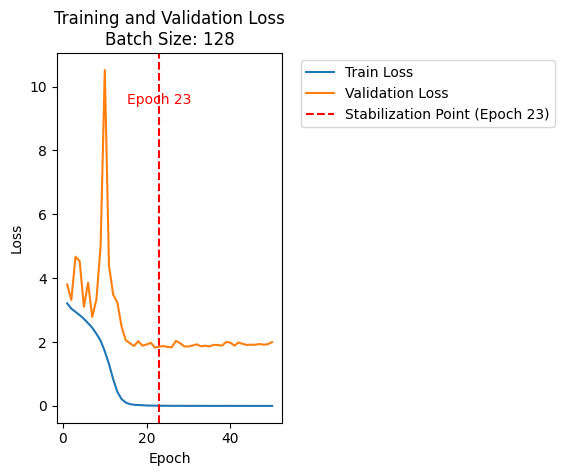

In [ ]:
# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.axvline(x=stabilization_epoch, color='red', linestyle='--', label=f'Stabilization Point (Epoch {stabilization_epoch})')
plt.text(stabilization_epoch, max(max(train_losses), max(val_losses)) * 0.9, f'Epoch {stabilization_epoch}', color='red', ha='center')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss\nBatch Size: 128')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

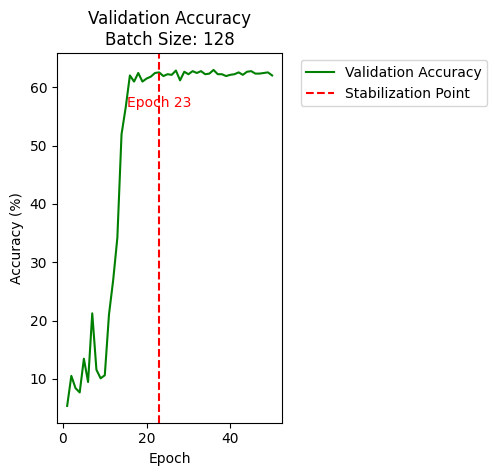

In [ ]:
# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.axvline(x=stabilization_epoch, color='red', linestyle='--', label='Stabilization Point')
plt.text(stabilization_epoch, max(val_accuracies) * 0.9, f'Epoch {stabilization_epoch}', color='red', ha='center')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Validation Accuracy\nBatch Size: 128')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>